# Sampling from a non-Gaussian pdf using a parametric approximation of the ICDF

### Goal

The scientific goal of this notebook is to determine how many Type Ia Supernova 'siblings' (SNe Ia) are required to tightly constrain their 'relative intrinsic scatter', $\sigma_{\rm{Rel}}$. 

### Domain Knowledge

To do this, we need to be able to simulate an arbitrary number of siblings distance estimates, and their individual measurement uncertainties. With a number of galaxies, $G$, each with 2 siblings, we can compute a posterior on $\sigma_{\rm{Rel}}$ across a population. Values of each galaxy's mean distance have no effect on the $\sigma_{\rm{Rel}}$ calculation, and $\sigma_{\rm{Rel}}$ is a pre-defined parameter in the simulation. Therefore, the part which affects our $\sigma_{\rm{Rel}}$ inference is the error on each distance estimate: the larger the errors, the wider the posterior on $\sigma_{\rm{Rel}}$, and therefore the more siblings galaxies that are required to tightly constrain this relative intrinsic scatter parameter.

We proceed to take *BayeSN* samples from individual fits to 236 SNe Ia. The resulting distribution of measurement errors are representative of the underlying distribution we would expect from a similar survey, were we to observe for longer and thus observe more siblings. **This is the non-Gaussian pdf we wish to simulate from.**

### Methods

We take the measurement error distribution, compute the CDF, extract 15 quantiles, invert, and interpolate the ICDF coordinates using a monotonic cubic spline. We then simulate from this distribution, allowing us to simulate an arbitrary number of siblings galaxies. We then ask, given the $\sigma_{\rm{Rel}}$ posteriors (which result from the measurement error distribution), how many siblings galaxies are required to 'tightly' constrain $\sigma_{\rm{Rel}}$. We define a good constraint to be $\approx$0.01 mag 68% uncertainty.



---
Firstly, import packages

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import copy, os, re, pickle
from glob import glob
import yaml
import sys
sys.path.append('model_files/')
from NONGAUSS import *
from sigmaRelPosteriors import *

Next, import modelling choices; these include the numbers of galaxies, $G$, we will probe, and reasonable values of the underlying relative intrinsic scatter, $\sigma_{\rm{Rel}}$

In [8]:
with open(f'choices.yaml') as f:
	choices = yaml.load(f, Loader=yaml.FullLoader)
globals().update(choices)
print (choices)

{'NSIBLINGs': [2], 'PRIORS': [1], 'Gmax': 1000, 'Gs': [10, 25, 50, 100, 200, 400, 800], 'SIGMARELs': [0.005, 0.025, 0.05, 0.075, 0.1], 'Nsims': 1000, 'Ndec': 1000, 'PRODUCTPATH': 'products/G_DICTS/', 'INTERVALSPATH': 'products/Intervals/', 'DATAPATH': 'data/X22_fits_210610_135216/', 'NAME': 'Foundation'}


Compute the distance measurement errors for the 236 SNe Ia, and collate samples

In [9]:
files = glob(choices['DATAPATH']+'*.npy') ; hist_samples = []
for f in files:
	samples        = np.load(f,allow_pickle=True).item()
	distance_error = (np.std(samples['mu'])**2 - np.std(samples['delM'])**2)**0.5
	hist_samples.append(distance_error)

Next we do the ICDF approximation, using the nonGauss class in model_files/

In [10]:
#Create nonGaussian Class
pdf = nonGauss(hist_samples)

#Get the CDF coordinates that will be inverted to create ICDF
pdf.get_ICDF_coords()

#Get the Monotonic cubic spline interpolation
pdf.get_ICDF_parametric_model()

Create some plots to show the samples' histogram, the empirical CDF, and the cubic approximation of the ICDF

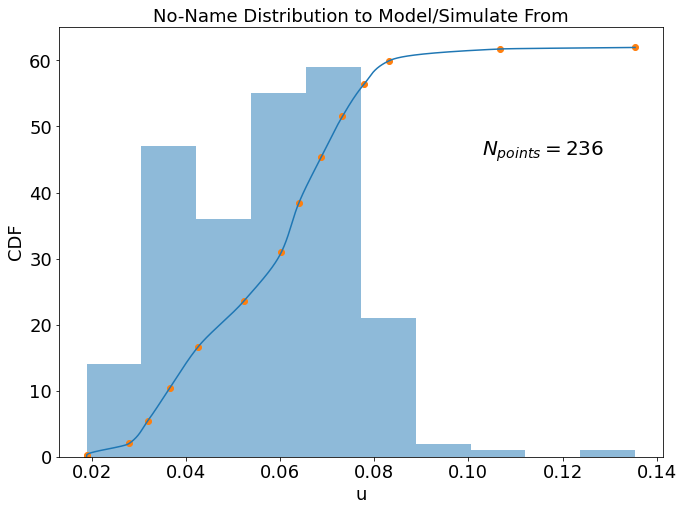

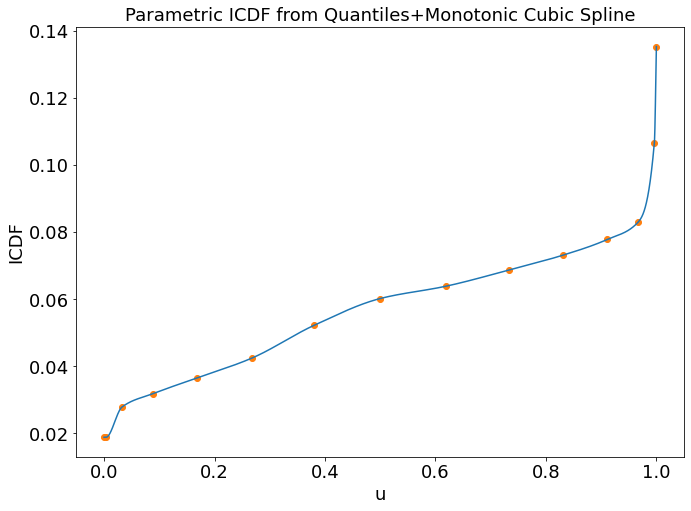

In [16]:
#Plot up the distribution we will approximate
pdf.plot_samples(show=False)
#Show the CDF quantiles
pdf.plot_CDF(create_new_plot=False,show=True,rescale=True)


#Plot ICDF
pdf.plot_ICDF()

At this stage, the time and space intensive operation is to loop over the various choices of the number of galaxies, $G$, the underlying value of $\sigma_{\rm{Rel}}$, and for each choice, perform 1000 simulations to marginalise over the Monte Carlo error (and thus obtain 'simulation-averaged' posteriors). This component is excluded from the notebook, but the important data (space-inexpensive) products are saved.

In [12]:
sgr = sigmaRelPosteriors(choices)

#Time and Space Intensive Line to Compute Posteriors over many grid parameter choices
#sgr.create_posterior_files(pdf)
#Final products are saved in GitHub

Final analysis product is a plot of the expected $\sigma_{\rm{Rel}}$ posteriors given observations of $G$ galaxies each with 2 SN Ia siblings.

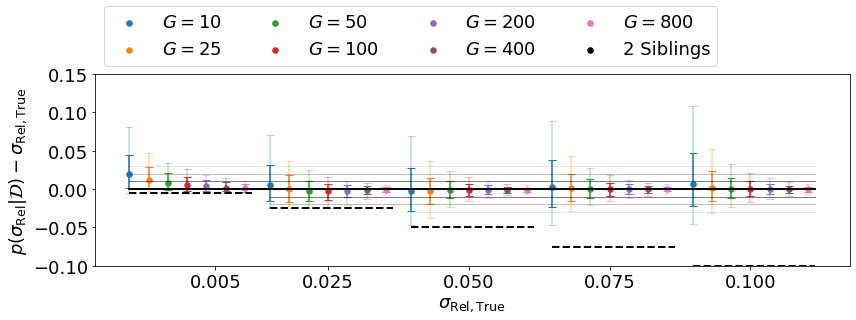

In [13]:
sgr.plot_intervals()

**From the above plot we can conclude that $\approx$ 100 siblings galaxies from this survey would yield a $\sigma_{\rm{Rel}}$ posterior with a $\approx$0.01 mag 68% uncertainty.**

Therefore, if we observed $G$ siblings galaxies, we could divide the sample into $\approx G/100$ bins, and compare $\sigma_{\rm{Rel}}$ in each bin. So for e.g. 400 observed siblings galaxies, we could split on host-galaxy stellar mass 4 times, and contrast 4 $\sigma_{\rm{Rel}}$ constraints.

Preliminary results show LSST-like surveys are not as powerful for constraining $\sigma_{\rm{Rel}}$, requiring $G=800$ to achieve the same level of precision; this is because LSST photometric cadence is smaller, leading larger errors on distance estimates, and thus wider relative scatter posteriors. This limits our ability to contrast $\sigma_{\rm{Rel}}$ constrained in different host-property bins.

**From this project we conclude either the photometric cadence of LSST needs to be increased to make full use of siblings, OR, we should be prioritising high-cadence follow-up of new SNe Ia observed in galaxies that have archival observations of a previous SN Ia; while this introduces cross calibration systematics, these effects are likely to be far less detrimental to the $\sigma_{\rm{Rel}}$ posteriors than the low photometric cadence of LSST.**